In [1]:
import os
import sys

notebook_path = os.path.abspath(".")
project_root = os.path.abspath(os.path.join(notebook_path, ".."))
os.chdir(project_root)

sys.path.append(os.path.join(project_root, "src"))

print(f"Current working directory: {project_root}")

Current working directory: /home/arian/deepLearning/del


# Eda

In [2]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import transforms
from src.utils import plot_training_curves

In [3]:
data_dir = os.path.join(project_root, "data", "original")

class_names = sorted(os.listdir(data_dir))
print(f"Anzahl Klassennamen: {len(class_names)}")
print(f"Beispiel-Klassennamen: {class_names[:5]}")

Anzahl Klassennamen: 10
Beispiel-Klassennamen: ['n02056570', 'n02085936', 'n02128757', 'n02690373', 'n02692877']


## Bilder pro Klasse

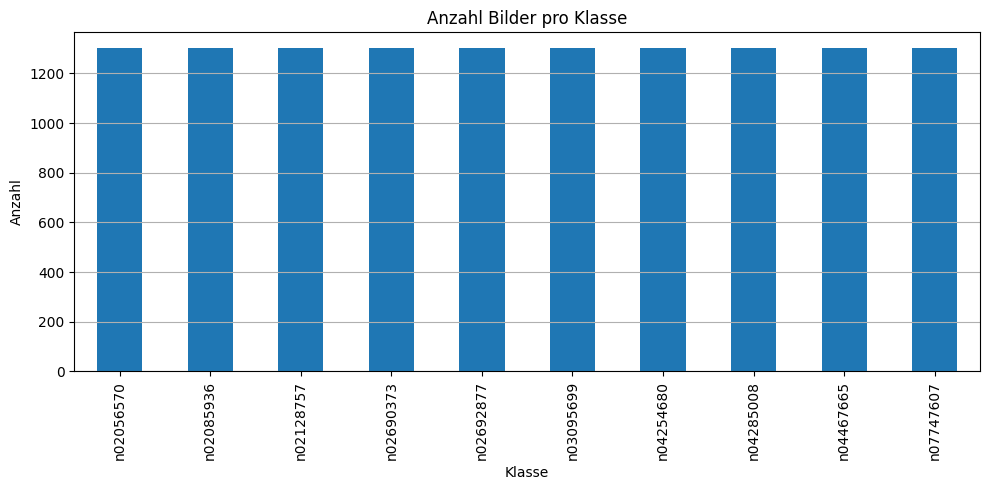

In [4]:
image_counts = {}

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    image_counts[class_name] = len(os.listdir(class_path))

# In DataFrame für Visualisierung
df_counts = pd.DataFrame.from_dict(image_counts, orient='index', columns=['Anzahl Bilder'])

# Plot
df_counts.plot(kind='bar', figsize=(10, 5), legend=False)
plt.title("Anzahl Bilder pro Klasse")
plt.xlabel("Klasse")
plt.ylabel("Anzahl")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Beispielbild jeder Klasse

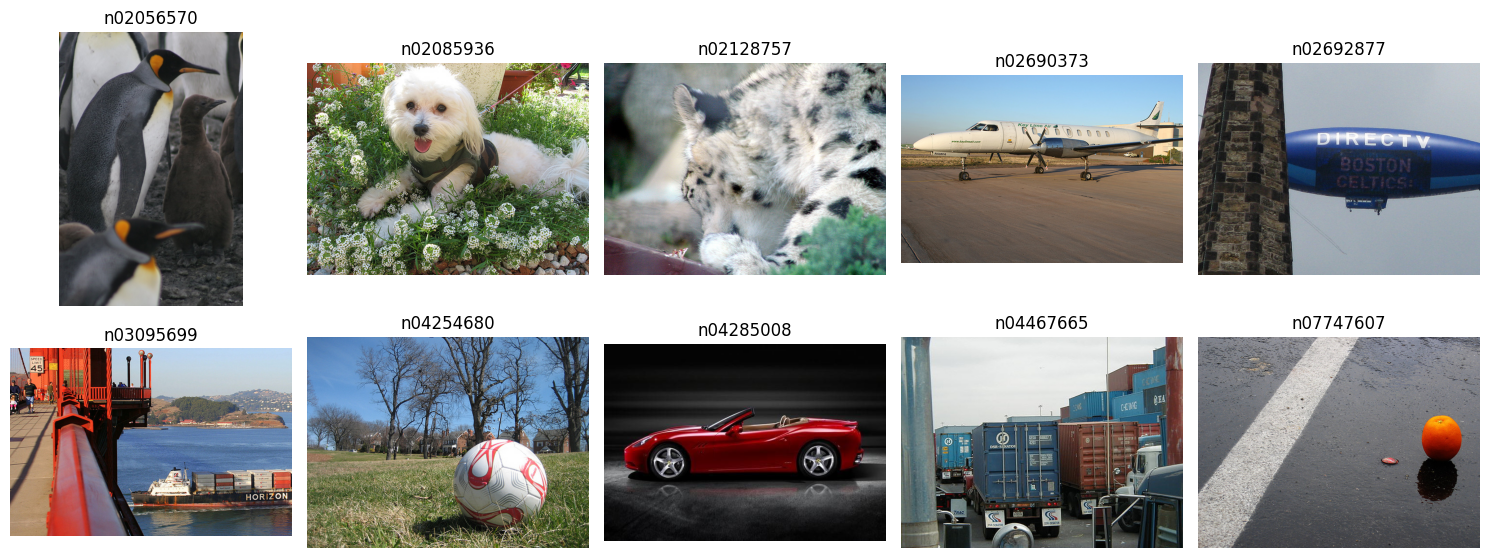

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, class_name in enumerate(class_names):
    img_path = os.path.join(data_dir, class_name, os.listdir(os.path.join(data_dir, class_name))[0])
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Bilder Eigenschaften

In [6]:
import random

folder_path = os.path.join(project_root, "data", "original", "n02056570")

# Get all JPEG files in the folder
jpeg_files = [f for f in os.listdir(folder_path) if f.endswith(".JPEG")]

# Randomly select up to 10 files
sample_files = random.sample(jpeg_files, min(5, len(jpeg_files)))

for filename in sample_files:
    image_path = os.path.join(folder_path, filename)
    image = Image.open(image_path)
    
    print(f"Filename: {filename}")
    print(f"Format: {image.format}")
    print(f"Size: {image.size}")
    print(f"Mode: {image.mode}")
    print("-" * 30)

Filename: n02056570_9123.JPEG
Format: JPEG
Size: (500, 281)
Mode: RGB
------------------------------
Filename: n02056570_116.JPEG
Format: JPEG
Size: (500, 375)
Mode: RGB
------------------------------
Filename: n02056570_9419.JPEG
Format: JPEG
Size: (500, 375)
Mode: RGB
------------------------------
Filename: n02056570_7470.JPEG
Format: JPEG
Size: (500, 378)
Mode: RGB
------------------------------
Filename: n02056570_18871.JPEG
Format: JPEG
Size: (500, 334)
Mode: RGB
------------------------------


## Klassenverteilung als Prozentwerte

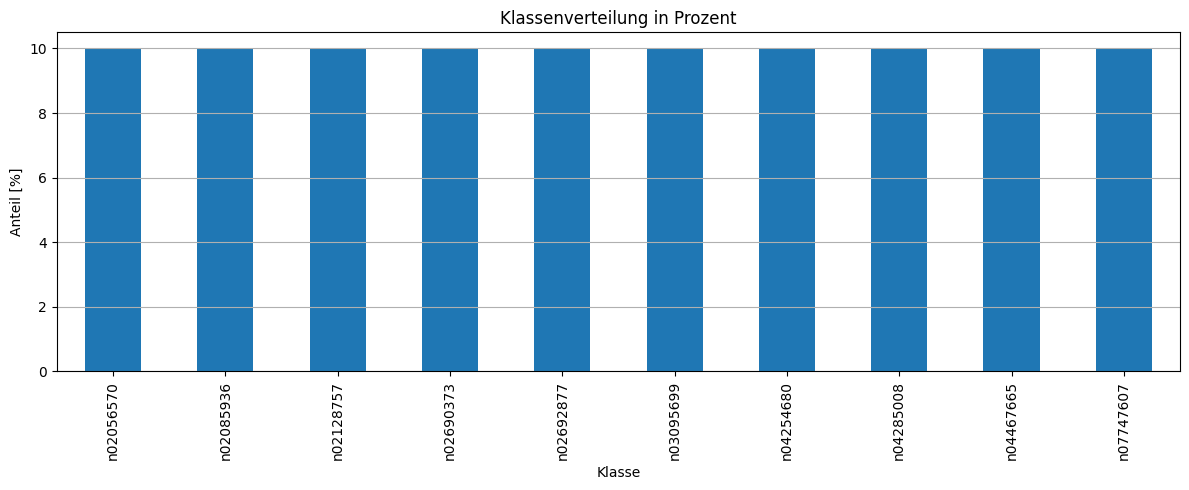

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

data_dir = project_root + "/data/original"
class_names = sorted(os.listdir(data_dir))

image_counts = {}

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    image_counts[class_name] = len(os.listdir(class_path))

df_counts = pd.DataFrame.from_dict(image_counts, orient='index', columns=['Anzahl'])
df_counts['Prozent'] = (df_counts['Anzahl'] / df_counts['Anzahl'].sum()) * 100

df_counts.sort_values("Prozent", ascending=False).plot(kind='bar', y='Prozent', legend=False, figsize=(12, 5))
plt.title("Klassenverteilung in Prozent")
plt.xlabel("Klasse")
plt.ylabel("Anteil [%]")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Hochformat vs. Querformat Analyse

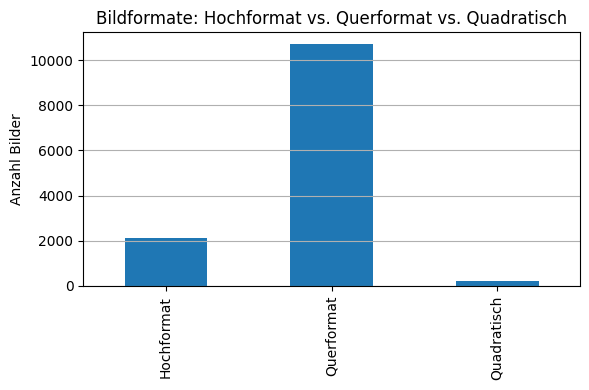

In [8]:
from PIL import Image

portrait_count = 0
landscape_count = 0
square_count = 0

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith(".jpeg"):
            img_path = os.path.join(class_path, fname)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    if height > width:
                        portrait_count += 1
                    elif width > height:
                        landscape_count += 1
                    else:
                        square_count += 1
            except Exception as e:
                print(f"Fehler bei Bild {img_path}: {e}")

format_counts = pd.Series({
    "Hochformat": portrait_count,
    "Querformat": landscape_count,
    "Quadratisch": square_count
})

format_counts.plot(kind='bar', figsize=(6, 4))
plt.title("Bildformate: Hochformat vs. Querformat vs. Quadratisch")
plt.ylabel("Anzahl Bilder")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Kontrolle der Farbkanäle

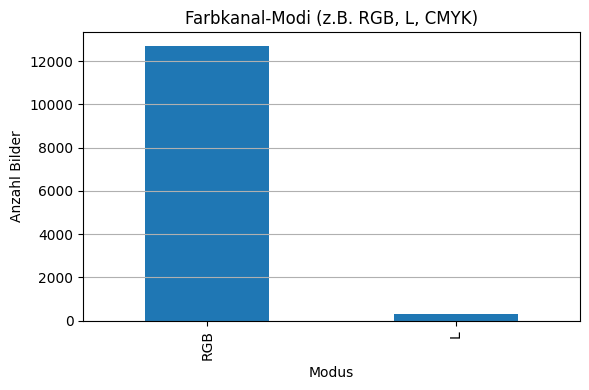

In [9]:
mode_counts = {}

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith(".jpeg"):
            img_path = os.path.join(class_path, fname)
            try:
                with Image.open(img_path) as img:
                    mode = img.mode
                    mode_counts[mode] = mode_counts.get(mode, 0) + 1
            except Exception as e:
                print(f"Fehler bei Bild {img_path}: {e}")

mode_series = pd.Series(mode_counts)
mode_series.plot(kind='bar', figsize=(6, 4))
plt.title("Farbkanal-Modi (z.B. RGB, L, CMYK)")
plt.xlabel("Modus")
plt.ylabel("Anzahl Bilder")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Preprocessing

## Splitting data

Split-ratios: \
train_ratio = 0.8 \
val_ratio = 0.1 \
test_ratio = 0.1

In [10]:
import os
import shutil
from glob import glob
from sklearn.model_selection import train_test_split

original_dir = os.path.join(project_root, "data", "original")
split_base_dir = os.path.join(project_root, "data", "split_data")

train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

# Zielverzeichnisse löschen und neu anlegen
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

# Split-Ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

class_names = sorted(os.listdir(original_dir))

for class_name in class_names:
    img_dir = os.path.join(original_dir, class_name)
    all_images = glob(os.path.join(img_dir, "*.JPEG"))

    train_imgs, temp_imgs = train_test_split(all_images, train_size=train_ratio, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)  # je 10%

    for split, img_list in zip(
        [train_dir, val_dir, test_dir],
        [train_imgs, val_imgs, test_imgs]
    ):
        target_class_dir = os.path.join(split, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        for img in img_list:
            shutil.copy(img, os.path.join(target_class_dir, os.path.basename(img)))

print("Train/Val/Test-Split abgeschlossen.")

Train/Val/Test-Split abgeschlossen.


## Bilder transformation

In [11]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

image_size = 224

# Transformationen
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets laden
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 10400, Val: 1300, Test: 1300


In [12]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Baseline model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Baseline CNN Modell

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Eingangsgröße nach 3x Pooling bei 224x224 Input: 28x28
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

### Modellinitialisierung, Loss, Optimizer

In [16]:
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### W&B initializing

In [17]:
import wandb

wandb.init(project="baseline-cnn-del", name="SimpleCNN_baseline", config={
    "architecture": "SimpleCNN",
    "epochs": 10,
    "batch_size": 32,
    "optimizer": "SGD",
    "learning_rate": 0.01,
    "loss": "CrossEntropyLoss",
    "dataset": "custom_split_data",
    "image_size": 224
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arian-iseni (arianarian) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## One Batch test

In [18]:
# Ein einzelner Batch (z. B. 4 Bilder) aus dem Trainloader
sample_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
sample_inputs, sample_targets = next(iter(sample_loader))

sample_inputs, sample_targets = sample_inputs.to(device), sample_targets.to(device)

print("Shape Input:", sample_inputs.shape)
print("Labels:", sample_targets)

Shape Input: torch.Size([4, 3, 224, 224])
Labels: tensor([0, 0, 5, 0], device='cuda:0')


In [19]:
model_test = SimpleCNN(num_classes=num_classes).to(device)
criterion_test = nn.CrossEntropyLoss()
optimizer_test = optim.SGD(model_test.parameters(), lr=0.01)

In [20]:
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    model_test.train()

    optimizer_test.zero_grad()
    outputs = model_test(sample_inputs)
    loss = criterion_test(outputs, sample_targets)
    loss.backward()
    optimizer_test.step()

    _, predicted = outputs.max(1)
    correct = predicted.eq(sample_targets).sum().item()
    acc = correct / sample_targets.size(0)

    loss_history.append(loss.item())

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")

Epoch 1 | Loss: 2.2928 | Accuracy: 0.0000
Epoch 2 | Loss: 1.8615 | Accuracy: 0.7500
Epoch 3 | Loss: 1.2883 | Accuracy: 0.7500
Epoch 4 | Loss: 0.8604 | Accuracy: 0.7500
Epoch 5 | Loss: 0.6738 | Accuracy: 0.7500
Epoch 6 | Loss: 0.5608 | Accuracy: 0.7500
Epoch 7 | Loss: 0.4720 | Accuracy: 0.7500
Epoch 8 | Loss: 0.3953 | Accuracy: 0.7500
Epoch 9 | Loss: 0.3300 | Accuracy: 1.0000
Epoch 10 | Loss: 0.2773 | Accuracy: 1.0000


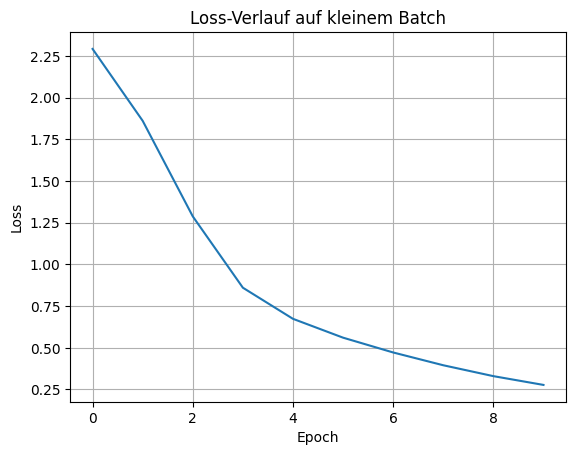

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Loss-Verlauf auf kleinem Batch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

### Trainingsloop

In [22]:
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

### Validierungsloop

In [23]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return running_loss / total, correct / total

### Training

In [24]:
from tqdm.notebook import trange
import os
import pickle
import hashlib

def get_model_hash(model, config):
    # Serialize model architecture and config for hashing
    model_str = str(model)
    config_str = str(config)
    hash_input = (model_str + config_str).encode('utf-8')
    return hashlib.md5(hash_input).hexdigest()

# Directory to store cached results
cache_dir = project_root + "/training_cache"
os.makedirs(cache_dir, exist_ok=True)

# Generate a unique hash for the current model and config
model_hash = get_model_hash(model, wandb.config)
cache_path = os.path.join(cache_dir, f"{model_hash}.pkl")

if os.path.exists(cache_path):
    # Load cached results
    with open(cache_path, "rb") as f:
        cached = pickle.load(f)
    train_losses = cached["train_losses"]
    val_losses = cached["val_losses"]
    train_accs = cached["train_accs"]
    val_accs = cached["val_accs"]
    print("Loaded cached training results for this model/config.")
    # Optionally, log to wandb if needed
    for epoch, (train_loss, train_acc, val_loss, val_acc) in enumerate(zip(train_losses, train_accs, val_losses, val_accs)):
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
else:
    num_epochs = wandb.config.epochs
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in trange(num_epochs, desc="Epochs"):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        # Save for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Log to console
        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
    # Save results to cache
    with open(cache_path, "wb") as f:
        pickle.dump({
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accs": train_accs,
            "val_accs": val_accs
        }, f)

Loaded cached training results for this model/config.


### Test-Set evaluation and logging

In [25]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

wandb.log({
    "test_loss": test_loss,
    "test_acc": test_acc
})

wandb.finish()

Test Loss: 2.3045, Test Accuracy: 0.0785


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_acc,▁▅▅▆▆▆▆█▇█
val_loss,█▅▄▄▃▃▄▁▂▁
epoch,10
test_acc,0.07846
test_loss,2.30449
train_acc,0.68692


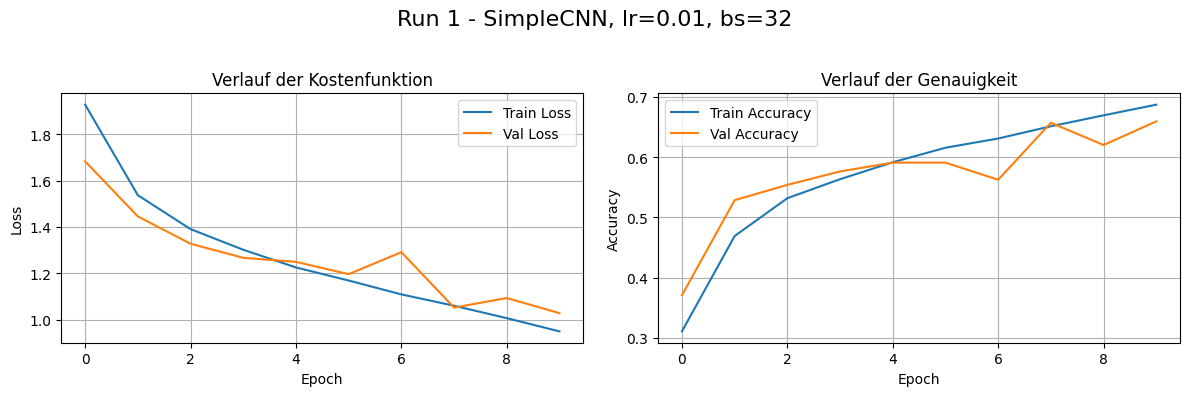

In [26]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs, run_number=1, model_name="SimpleCNN", learning_rate=0.01, batch_size=32)

### Crossfold validation

In [27]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import numpy as np

def cross_validate_model(model_class, dataset, num_classes, k=5, epochs=5, batch_size=32, lr=0.01):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    targets = [label for _, label in dataset]

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        print(f"\n Fold {fold+1}/{k}")

        # Teilmengen erzeugen
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Neues Modell pro Fold
        model = model_class(num_classes=num_classes).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training & Evaluation
        for epoch in range(epochs):
            train_loss, train_acc = train(model, train_loader, optimizer, criterion)
            val_loss, val_acc = evaluate(model, val_loader, criterion)
            print(f"  Epoch {epoch+1}/{epochs}: Val Acc = {val_acc:.4f}")

        # Ergebnis für diesen Fold speichern
        fold_results.append(val_acc)

    # Statistischer Fehler (Mittelwert und Standardabweichung)
    mean_acc = np.mean(fold_results)
    std_acc = np.std(fold_results)

    print(f"\n Durchschnittliche Accuracy: {mean_acc:.4f}")
    print(f"Standardabweichung (statistischer Fehler): {std_acc:.4f}")

    return fold_results, mean_acc, std_acc

In [28]:
#5-fold CV mit 3 Epochen pro Fold (damit es schnell geht)
folds, mean_acc, std_acc = cross_validate_model(
    model_class=SimpleCNN,
    dataset=train_dataset,
    num_classes=len(train_dataset.classes),
    k=5,
    epochs=3,
    batch_size=32,
    lr=0.01
)


 Fold 1/5
  Epoch 1/3: Val Acc = 0.4091
  Epoch 2/3: Val Acc = 0.5125
  Epoch 3/3: Val Acc = 0.5779

 Fold 2/5
  Epoch 1/3: Val Acc = 0.4221
  Epoch 2/3: Val Acc = 0.5240
  Epoch 3/3: Val Acc = 0.5332

 Fold 3/5
  Epoch 1/3: Val Acc = 0.4447
  Epoch 2/3: Val Acc = 0.5361
  Epoch 3/3: Val Acc = 0.5630

 Fold 4/5
  Epoch 1/3: Val Acc = 0.4630
  Epoch 2/3: Val Acc = 0.5072
  Epoch 3/3: Val Acc = 0.5697

 Fold 5/5
  Epoch 1/3: Val Acc = 0.4245
  Epoch 2/3: Val Acc = 0.5101
  Epoch 3/3: Val Acc = 0.5736

 Durchschnittliche Accuracy: 0.5635
Standardabweichung (statistischer Fehler): 0.0159
